<a href="https://colab.research.google.com/github/LeandroCoelhos/estudos_datascience/blob/main/calibracao_modelos/calibracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Conjunto de dados previamente tratado, somente usado para exemplo rápido

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/LeandroCoelhos/estudos_datascience/main/calibracao_modelos/base_calibracao.csv')
df

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,1957,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,0,0,0,1,0,0,0
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,0,0,1,0,0,0
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,0,0,0,1,0,0
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,0,0,0,1,0,0
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,0,0,1,0,0,0,0
2236,1946,64014.0,2,1,56,406,0,30,0,0,...,0,1,0,0,0,0,0,1,0,0
2237,1981,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,0,1,0,0,0,0,0
2238,1956,69245.0,0,1,8,428,30,214,80,30,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
X = df.drop('Response',axis=1)
y = df.Response

from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=0.50)

## RobustScaler

pega sua mediana como ponto central zero

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaler.fit(X_tr)

X_tr_s = scaler.transform(X_tr)
X_ts_s = scaler.transform(X_ts)

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_tr_s, y_tr)

GaussianNB()

In [ ]:
from sklearn.metrics import roc_auc_score

preds = gnb.predict_proba(X_ts_s)[:,1]

roc_auc_score(y_ts, preds)

0.7872022681922659

## Note que o modelo não solta a probabilidade
Se fosse probabilidade, ele seguiria uma tendencia linear conforme as probabilidades aumentam, sem essa queda depois dos 40%

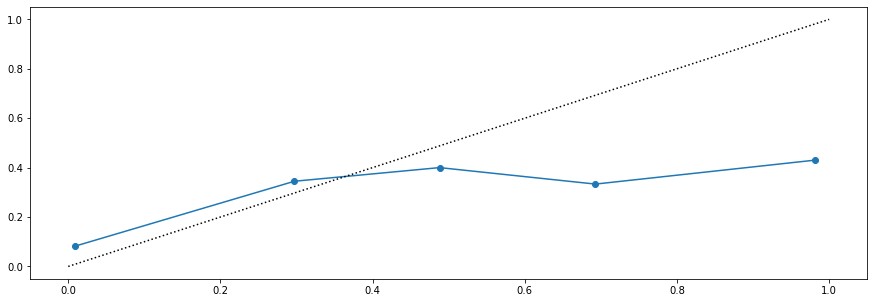

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_ts, preds)

plt.figure(figsize=(15,5))
plt.plot(prob_pred, prob_true,'o-')
plt.plot((0,1),(0,1),'k:')

## Treinar a regressão logistica apenas com a saida do Nayv

A ideia é treinar uma regressão logistica com os scores soltos pelo Nayv
Mas note que temos que tomar um cuidado, pois usamos os scores do conjunto de teste do nayv para treinar nossa regressão, então precisamos dividir novamente nosso conjunto

Isso fasz com que nosso conjuntod e teste fique ainda menor, o que pode ser um problema

In [ ]:
X_tr2, X_ts2, y_tr2, y_ts2 = train_test_split(X_ts_s, y_ts, test_size=.50)

from sklearn.linear_model import LogisticRegression

preds_tr = gnb.predict_proba(X_tr2)[:,1]
preds_ts = gnb.predict_proba(X_ts2)[:,1]

lr = LogisticRegression(penalty='none')

pred_tr_df = pd.DataFrame(np.array([preds_tr]).T,columns=['pred'])
pred_ts_df = pd.DataFrame(np.array([preds_ts]).T,columns=['pred'])

lr.fit(pred_tr_df, y_tr2)

preds_2 = lr.predict_proba(pred_ts_df)[:,1]

## Não vemos grande diferença na AUC
Pois já estamos partindo de uma boa ordenação, o impacto da regressão é somente em esticar ou melhor, em mudar um pouco o formato desse score para uma curva de problabilidade

In [ ]:
print('Original: ', roc_auc_score(y_ts2, preds_ts) )
print('Reg.Log.: ', roc_auc_score(y_ts2, preds_2) )

Original:  0.7889004149377593
Reg.Log.:  0.7890999042451324


## Note que o Score encolheu
Isso aconteceu porque a regressão considerou o Nayv uma modelo otimista demais, então considerou que não deveriam haver pessoas com score de 100% nem com 0%

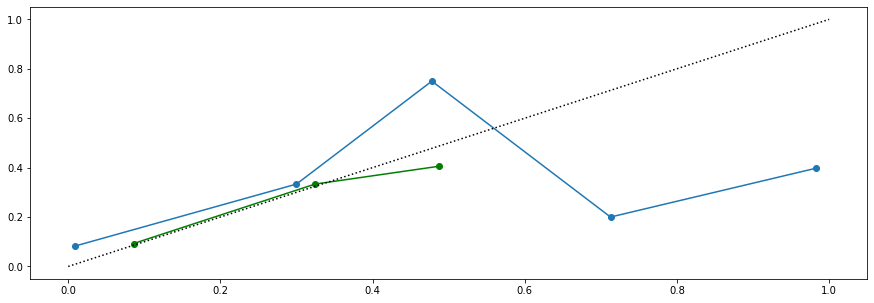

In [ ]:
prob_true, prob_pred = calibration_curve(y_ts2, preds_ts)
prob_true_2, prob_pred_2 = calibration_curve(y_ts2, preds_2)

plt.figure(figsize=(15,5))
plt.plot(prob_pred, prob_true,'o-')
plt.plot(prob_pred_2, prob_true_2,'go-')
plt.plot((0,1),(0,1),'k:')

(array([0.        , 7.17948718, 0.8974359 , 0.17948718, 0.17948718,
        0.17948718, 5.38461538, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ]),
 <BarContainer object of 14 artists>)

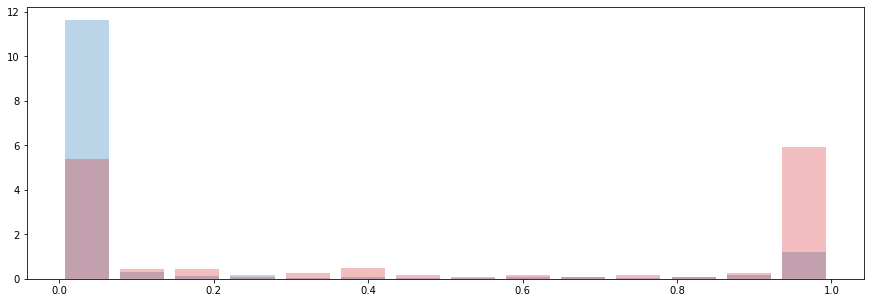

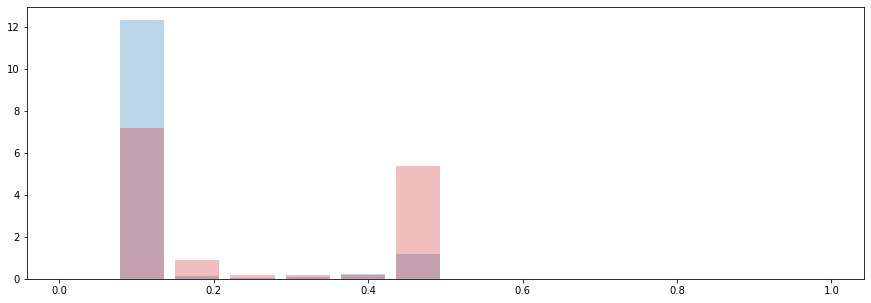

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(preds[y_ts==0], bins=np.linspace(0,1,15),rwidth=.8, alpha=.3, color='C0',density=True)
plt.hist(preds[y_ts==1], bins=np.linspace(0,1,15),rwidth=.8, alpha=.3, color='C3',density=True)

plt.figure(figsize=(15,5))
plt.hist(preds_2[y_ts2==0], bins=np.linspace(0,1,15),rwidth=.8, alpha=.3, color='C0',density=True)
plt.hist(preds_2[y_ts2==1], bins=np.linspace(0,1,15),rwidth=.8, alpha=.3, color='C3',density=True)